In [67]:
# create and evaluate a static autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Scipy for statistics
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
# PyMC3 for Bayesian Inference
import pymc3 as pm
import arviz as az

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

## by formula

In [2]:
# load dataset
series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]

In [4]:
print("len(series):\t", len(series))
print("len(train):\t", len(train))
print("len(test):\t", len(test))

len(series):	 3650
len(train):	 3642
len(test):	 7


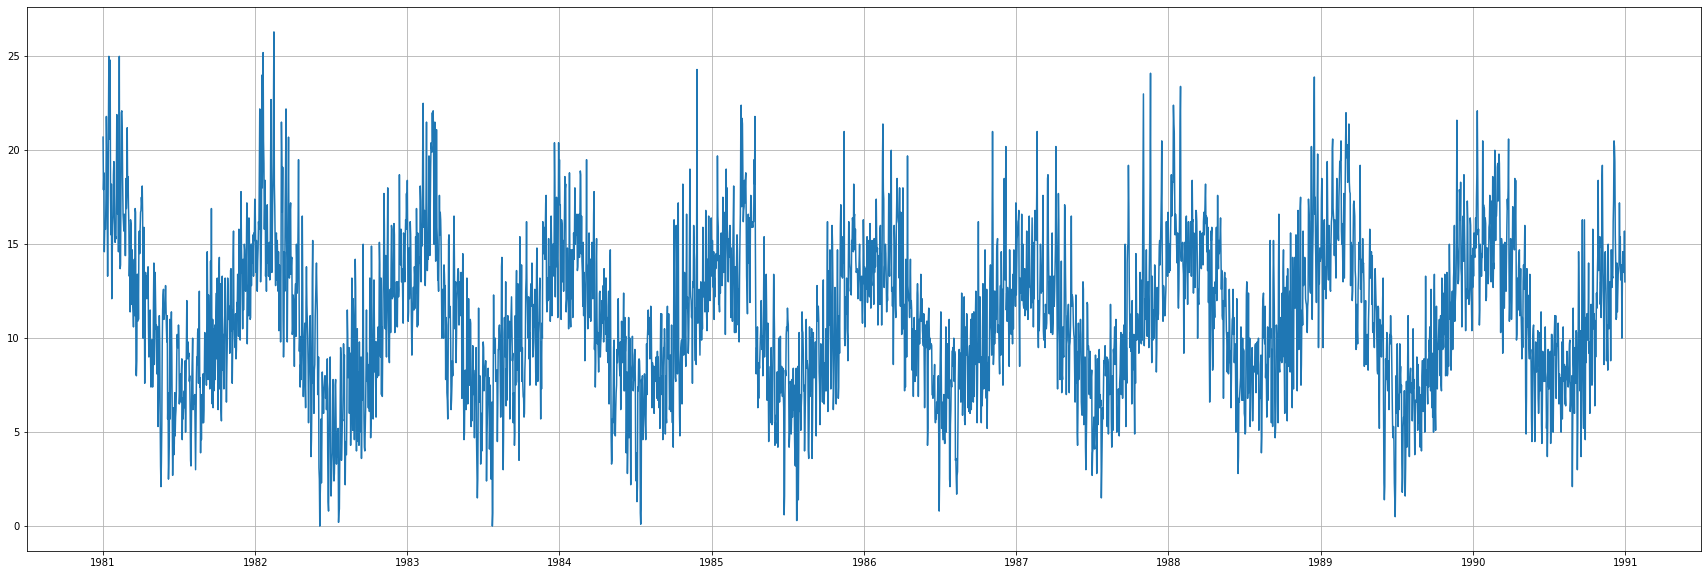

In [63]:
plt.figure(figsize= (30,10))
plt.plot(series)
plt.grid()

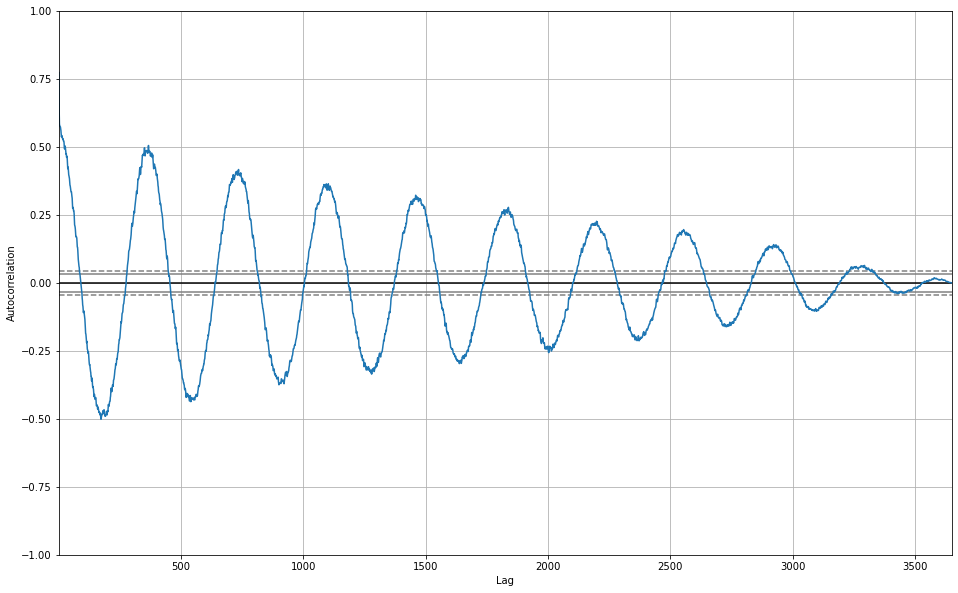

In [65]:
plt.figure(figsize= (16,10))
autocorrelation_plot(series)

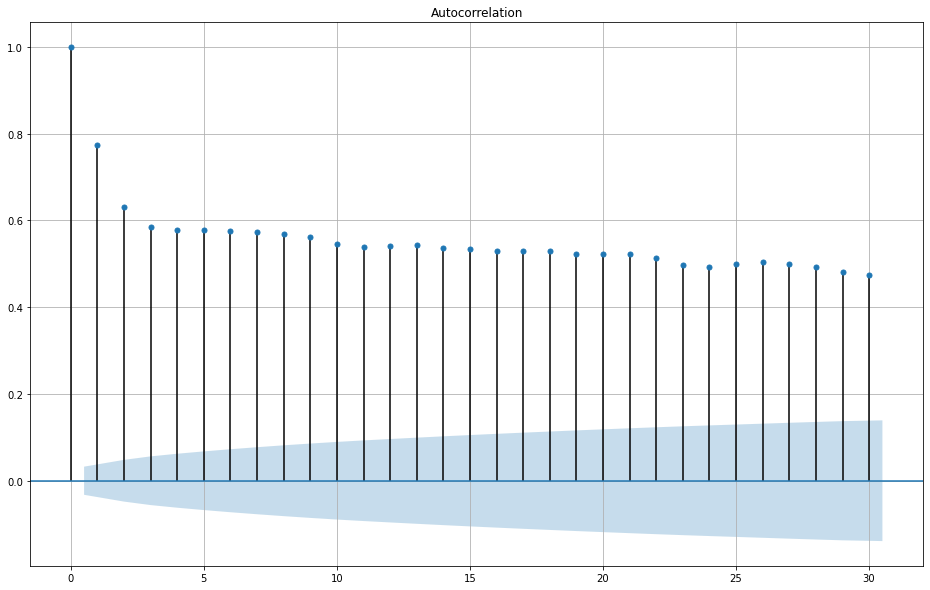

In [68]:
plt.rc("figure", figsize=(16,10))
plot_acf(series, lags=30)
plt.grid()
pyplot.show()

In [69]:
AutoReg?

Coefficients: [ 1.88287666  0.70055426 -0.05985435  0.19052746]
predicted=10.571406, expected=12.900000
predicted=11.338509, expected=14.600000
predicted=11.098647, expected=14.000000
predicted=10.993565, expected=13.600000
predicted=11.080461, expected=13.500000
predicted=11.101925, expected=15.700000
predicted=11.091740, expected=13.000000
Test RMSE: 2.974


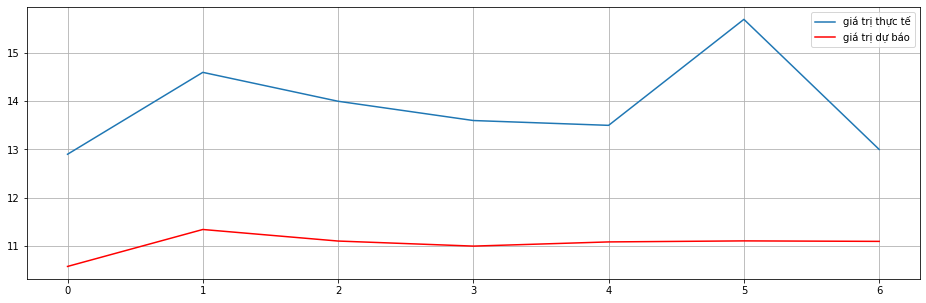

In [60]:
# train autoregression
model = AutoReg(train, lags=3)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.figure(figsize = (16,5))
pyplot.plot(test, label = "giá trị thực tế")
pyplot.plot(predictions, color='red', label = "giá trị dự báo")
pyplot.legend()
pyplot.grid()
pyplot.show()

## by hand

In [5]:
def get_X_train(p,df_temp):
    #Generating the lagged p terms
    for i in range(1,p+1):
        df_temp['Shifted_values_%d' % i ] = df_temp['Temp'].shift(i)
    df_temp = df_temp.dropna()
    #X contains the lagged values ,hence we skip the first column
    X_train = df_temp.iloc[:,1:].values.reshape(-1,p)
    y_train = df_temp.iloc[:,0].values.reshape(-1,1)[:,0]
    return X_train, y_train

In [6]:
# create df_temp for processing X_train
df_temp = pd.DataFrame({"Temp": train})

In [7]:
df_temp

,Temp
0,17.9
1,18.8
2,14.6
3,15.8
4,15.8
...,...
3637,15.4
3638,13.1
3639,13.2
3640,13.9


In [8]:
X_train, y_train = get_X_train(p = 3,df_temp = df_temp) # lags = 3

In [10]:
print("X_train:\t")
print()
print(X_train)

X_train:	

[[14.6 18.8 17.9]
 [15.8 14.6 18.8]
 [15.8 15.8 14.6]
 ...
 [13.1 15.4 14.7]
 [13.2 13.1 15.4]
 [13.9 13.2 13.1]]


In [11]:
print("y_train:\t")
print()
print(y_train)

y_train:	

[15.8 15.8 15.8 ... 13.2 13.9 10. ]


In [12]:
# get parameters of AR(3)
reg = LinearRegression().fit(X_train, y_train)
print(reg.intercept_)
print(reg.coef_)

1.8828766551944316
[ 0.70055426 -0.05985435  0.19052746]


In [70]:
def predict(timeseries, reg, times, lag):
    timeseries_cp = list(timeseries.copy())
    ls_predict = []
    for i in range(times):
        res = np.dot(timeseries_cp[-lag:][::-1], reg.coef_) + reg.intercept_
        res = round(res, 6)
        timeseries_cp.append(res)
        ls_predict.append(res)
    return timeseries_cp, ls_predict

### create design matrix

In [14]:
def get_X_design(X_train):
    vector_ones = (np.ones(len(X_train)))
    X_design = np.concatenate((np.expand_dims(vector_ones, 1), X_train), axis = 1)
    return X_design

In [15]:
X_design = get_X_design(X_train)
print(X_design)

[[ 1.  14.6 18.8 17.9]
 [ 1.  15.8 14.6 18.8]
 [ 1.  15.8 15.8 14.6]
 ...
 [ 1.  13.1 15.4 14.7]
 [ 1.  13.2 13.1 15.4]
 [ 1.  13.9 13.2 13.1]]


In [16]:
def get_sigma_square(X_design, y_train, num_of_paras):
    H_matrix = np.matrix(X_design)*np.linalg.inv((np.matrix(X_design).T * np.matrix(X_design)))*np.matrix(X_design).T
    sigma_square = (np.matrix(y_train).T.T*(np.matrix(np.identity(len(H_matrix))) - H_matrix)*np.matrix(y_train).T)[0,0]/(len(X_design) - num_of_paras - 1)
    return sigma_square

In [18]:
sigma_square = get_sigma_square(X_design, y_train, num_of_paras = 3)
print("sigma_square:\t", sigma_square)

sigma_square:	 6.352706908519363


In [19]:
sigma = sigma_square**0.5

## run model

In [28]:
ls_para = ["beta_0", "beta_1", "beta_2", "beta_3"]

In [29]:
with pm.Model() as BAR_model:
    # Intercept
    beta_0 = pm.Normal(ls_para[0], mu = 0, sd = 10)
    
    # Slope 
    beta_1 = pm.Normal(ls_para[1], mu = 0, sd = 10)
    beta_2 = pm.Normal(ls_para[2], mu = 0, sd = 10)
    beta_3 = pm.Normal(ls_para[3], mu = 0, sd = 10)
    
#     # Standard deviation
#     sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = beta_0 + beta_1*X_train[:,0] + beta_2*X_train[:,1] + beta_3*X_train[:,2]
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y_train)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    BAR_trace = pm.sample(1000, step, random_seed = 0)

C:\Users\Lennovo\AppData\Roaming\Python\Python38\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_3, beta_2, beta_1, beta_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Lennovo\AppData\Roaming\Python\Python38\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


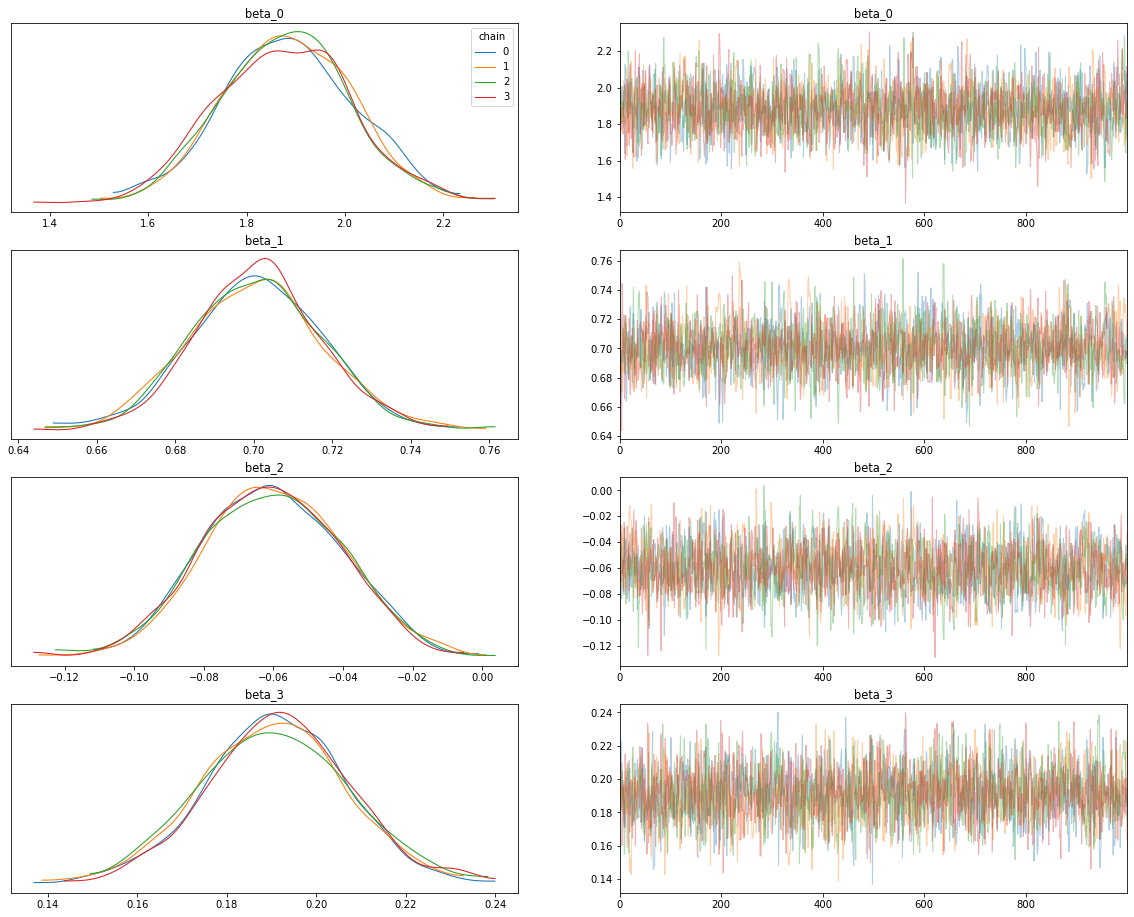

In [30]:
# plot posterior distribution
az.plot_trace(BAR_trace, figsize = (20, 16), compact = False, legend = True);

In [31]:
with BAR_model:
    trace_az = az.from_pymc3(BAR_trace)
az.summary(trace_az)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,1.882,0.133,1.642,2.138,0.003,0.002,2515.0,2003.0,1.00
beta_1,0.701,0.017,0.669,0.731,0.000,0.000,2234.0,1962.0,1.00
beta_2,-0.060,0.020,-0.097,-0.025,0.000,0.000,2143.0,2371.0,1.00
beta_3,0.191,0.016,0.159,0.219,0.000,0.000,2121.0,2204.0,1.01


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Lennovo\AppData\Roaming\Python\Python38\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


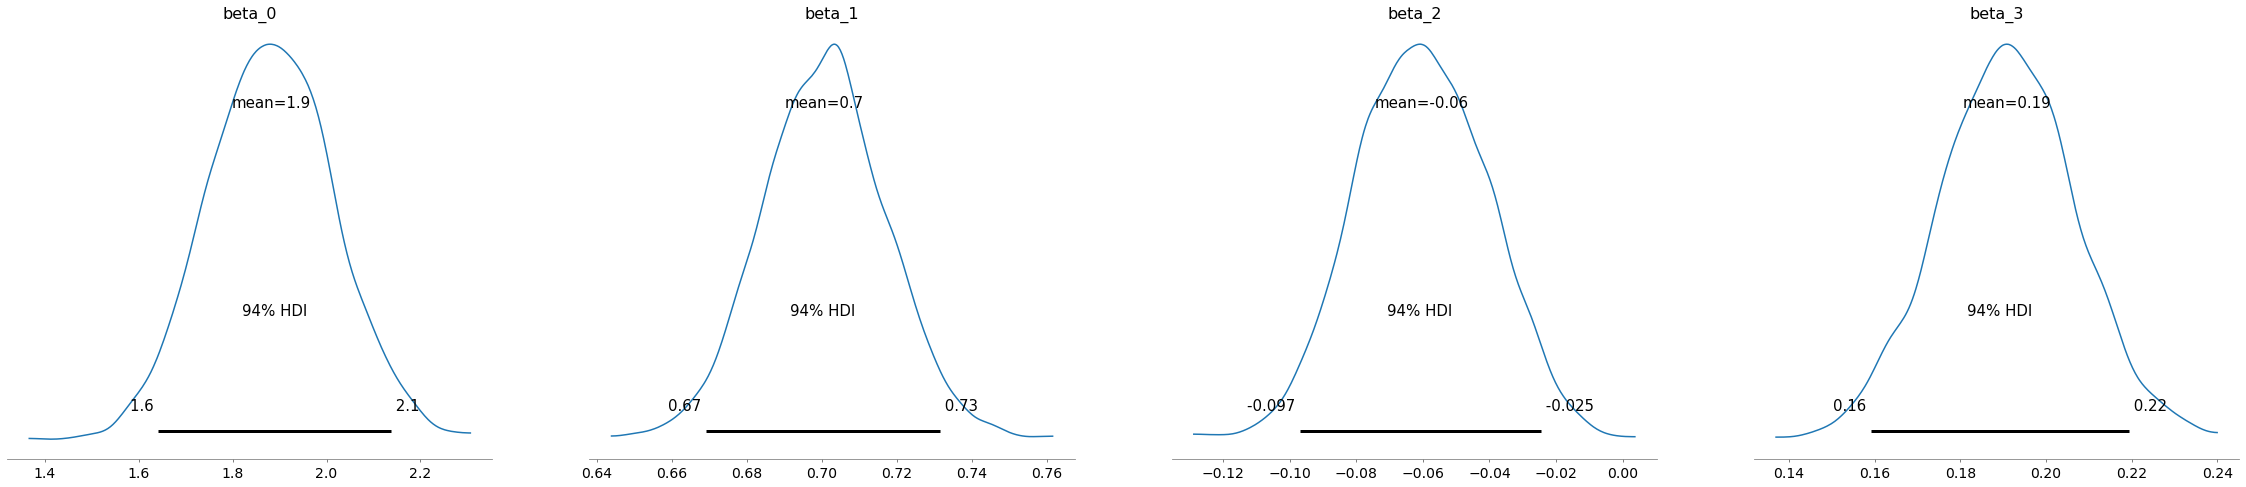

In [32]:
pm.plot_posterior(BAR_trace, figsize = (40,8));

In [33]:
def predict_distribution(timeseries, BAR_trace, ls_para, lags = 3):
    '''
    predict distribution of next observed 
    '''
    timeseries_cp = list(timeseries.copy())
    res = BAR_trace[ls_para[0]]
    for p in range(1, len(ls_para)):
        res += BAR_trace[ls_para[p]]*timeseries_cp[-p]
    return res

In [35]:
def predict_distribution_by_time(timeseries, BAR_trace, ls_para, lags = 3, num_nextday = 1):
    ls_res = []
    timeseries_cp = list(timeseries.copy())
    for i in range(num_nextday):
        distribution_res = predict_distribution(timeseries_cp, BAR_trace, ls_para, lags)
        timeseries_cp.append(np.mean(distribution_res))
        ls_res.append(distribution_res)
    return ls_res

In [34]:
predict_distribution(train, BAR_trace, ls_para, lags = 3)

array([10.45118413, 10.60297302, 10.66128066, ..., 10.62640262,
       10.50951059, 10.57526749])

In [36]:
ls_res = predict_distribution_by_time(train, BAR_trace, ls_para, lags = 3, num_nextday = 7)

In [37]:
ls_res

[array([10.45118413, 10.60297302, 10.66128066, ..., 10.62640262,
        10.50951059, 10.57526749]),
 array([11.35932027, 11.43743215, 11.44171902, ..., 11.40097702,
        11.31607338, 11.36510998]),
 array([11.06755096, 11.13221467, 11.04517337, ..., 11.12112087,
        11.09421877, 11.10622244]),
 array([10.94049567, 11.02337311, 10.96459867, ..., 11.02124261,
        10.9762949 , 10.99891547]),
 array([11.04237798, 11.12476851, 11.08100063, ..., 11.11596034,
        11.06097381, 11.09007673]),
 array([11.06575088, 11.14413506, 11.09174807, ..., 11.13494711,
        11.08508394, 11.11102125]),
 array([11.05173573, 11.13081793, 11.07688073, ..., 11.12347726,
        11.07436576, 11.09972003])]

In [40]:
ls_mean_of_ls_res = [res.mean() for res in ls_res]
ls_std_of_ls_res = [res.std() for res in ls_res]

In [41]:
ls_mean_of_ls_res

[10.570305290873659,
 11.338770556891264,
 11.098556966628642,
 10.992720281822864,
 11.079705672430304,
 11.101199198805036,
 11.090815165797277]

In [39]:
ls_std_of_ls_res

[0.07323208905390159,
 0.07292969097026063,
 0.04386935777280529,
 0.04218749395681938,
 0.04112257471516372,
 0.040851753470222164,
 0.0407644488427952]

In [56]:
def get_credible_interval_of_predict_distribution(ls_res, Z_alpha_over_2):
    ls_credible_interval = []
    for res in ls_res:
        low = res.mean() - Z_alpha_over_2*res.std()
        high = res.mean() + Z_alpha_over_2*res.std()
        ls_credible_interval.append((round(low, 4), round(high, 4)))
    return ls_credible_interval

In [57]:
ls_credible_interval = get_credible_interval_of_predict_distribution(ls_res = ls_res, Z_alpha_over_2 = 1.96)

In [58]:
ls_credible_interval

[(10.4268, 10.7138),
 (11.1958, 11.4817),
 (11.0126, 11.1845),
 (10.91, 11.0754),
 (10.9991, 11.1603),
 (11.0211, 11.1813),
 (11.0109, 11.1707)]

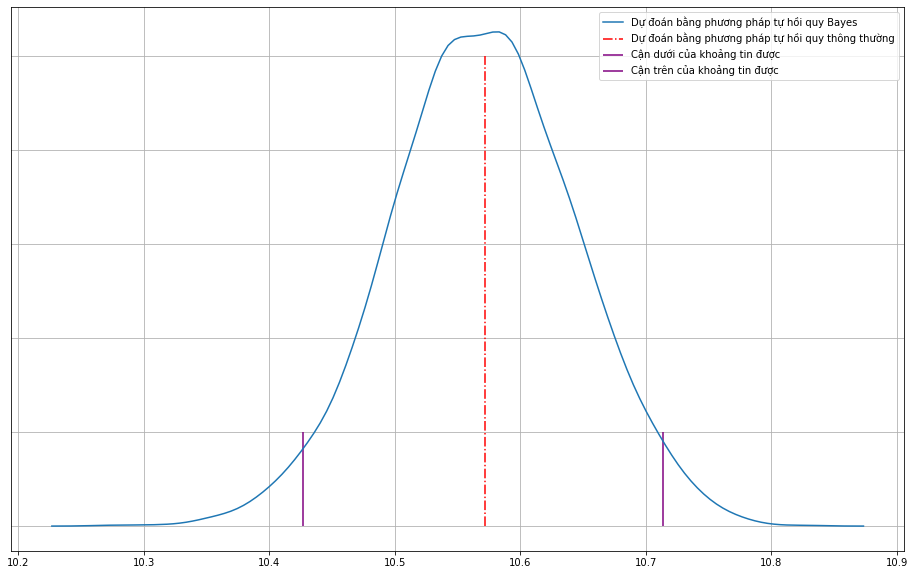

In [77]:
pyplot.figure(figsize = (16,10))
sns.kdeplot(ls_res[0], label = 'Dự đoán bằng phương pháp tự hồi quy Bayes')
pyplot.vlines(x = 10.571406, 
           ymin = 0, ymax = 5, 
           label = 'Dự đoán bằng phương pháp tự hồi quy thông thường',
          colors = 'red', linestyles='-.')
plt.vlines(x = ls_credible_interval[0][0], 
           ymin = 0, ymax = 1, 
           label = 'Cận dưới của khoảng tin được',
          colors = 'purple', linestyles='-')
plt.vlines(x = ls_credible_interval[0][1], 
           ymin = 0, ymax = 1, 
           label = 'Cận trên của khoảng tin được',
          colors = 'purple', linestyles='-')
pyplot.grid()
pyplot.legend()
pyplot.tick_params(labelleft=False, left=False)